# Overview
This notebook identifies significant r values
* fisherZ correct
* stack across participants and runs
* run t-test and identify r values greater than 0
* reconvert fisherZ back to correlation coefficients
* stack coefficients across hemisphere for multiple comparisons
* save results in corresponding hemisphere while preserving medial/non-medial wall vertices

### modules

In [1]:
import numpy as np
import pandas as pd
import os
from os.path import join
import scipy.stats
from statsmodels.stats.multitest import multipletests
import nibabel as nib
from pathlib import Path

### function: write_gifti

In [2]:
def write_gifti(data, output_fn, template_fn):
    gii = nib.load(template_fn)
    for i in np.arange(gii.numDA):
        gii.remove_gifti_data_array(0)
    gda = nib.gifti.GiftiDataArray(data)
    gii.add_gifti_data_array(gda)
    nib.gifti.giftiio.write(gii, output_fn)

### parameters

In [3]:
suma_dir = '/Users/h/suma-fsaverage6'
main_dir = '/dartfs/rc/lab/D/DBIC/DBIC/f0042x1/life-encoding'
main_dir = '/Volumes/life-encoding'
output_dir = os.path.join(main_dir, 'results', 'himalaya', 'ha_common')
alignment = 'ha_common'
results = ['bg-r', 'actions-r',  'agents-r']
runs = [1, 2, 3, 4]
hemis = ['lh', 'rh']
fmri_durs = {1: 374, 2: 346, 3: 377, 4: 412}
n_samples = 1509
n_vertices = 40962
n_medial = {'lh': 3486, 'rh': 3491}
subjects = ['sub-rid000001', 'sub-rid000005', 'sub-rid000006',
            'sub-rid000009', 'sub-rid000012', 'sub-rid000014',
            'sub-rid000017', 'sub-rid000019', 'sub-rid000024',
            'sub-rid000027', 'sub-rid000031', 'sub-rid000032',
            'sub-rid000033', 'sub-rid000034', 'sub-rid000036',
            'sub-rid000037', 'sub-rid000038', 'sub-rid000041']

In [20]:
for result in results:
    hemi_t = []
    hemi_p = []
    hemi_mean = []
    print(f"starting {result} ________________")
    for hemisphere in hemis:
        medial_mask = np.load(os.path.join(main_dir, 'data', f'fsaverage6_medial_{hemisphere}.npy'))
        assert np.sum(medial_mask) == n_medial[hemisphere]
        cortical_vertices = ~medial_mask # boolean (true for non-medials, false for medials)
        cortical_coords = np.where(cortical_vertices)[0] # returns indices of non-medials
        avg_all = []
        # NOTE 1. Fisher z transform per run per participant (np.arctanh)
        for test_subject in subjects:
            stack_fisherz_run = []
            for test_run in runs:           
                run_data = np.load(f"{output_dir}/{result}_align-{alignment}_{test_subject}_run-{test_run}_hemi-{hemisphere}.npy")
                fisherz_run = np.arctanh(run_data[0, cortical_vertices])
                stack_fisherz_run.append(fisherz_run)
        
            # NOTE: 2. average (z-transformed) correlations across runs: yields 18 maps (1 per subject)
            avg_run = np.mean(np.vstack(stack_fisherz_run), axis = 0)
            avg_all.append(avg_run)
        fisherz_all = np.vstack(avg_all) # 18 x nonmedial (per hemi)

        # NOTE: 3. Scipy ttest_1samp to get t-value and p-value
        t, p = scipy.stats.ttest_1samp(fisherz_all, popmean=0,axis=0, alternative='greater')
        hemi_t.append(t)
        hemi_p.append(p)
        hemi_mean.append(np.tanh(np.nanmean(fisherz_all, axis = 0)))

    # %% NOTE: 4-1. concatenate (np.hstack) the two hemispheres p-values (and exclude medial wall) prior to computing FDR (load in cortical_vertices.npy)
    left_vert = hemi_p[0].shape[0]
    t_all = np.hstack(hemi_t)
    p_all = np.hstack(hemi_p)

    reject, q_all, _, _ = multipletests(p_all, method = 'fdr_bh')
    q_both = [q_all[:left_vert], q_all[left_vert:]]
    print("* completed t-tests for both hemispheres")
    hemilabels = ['lh', 'rh']
    Path(join(output_dir, 'stats')).mkdir(parents = True, exist_ok = True)
    for h, hemisphere in enumerate(hemis):
        stats = np.zeros((n_vertices))
        hemi_mean[h][q_both[h] >= .05] = 0
        medial_mask = np.load(os.path.join(main_dir, 'data', f'fsaverage6_medial_{hemisphere}.npy'))
        assert np.sum(medial_mask) == n_medial[hemisphere]
        cortical_vertices = ~medial_mask # boolean (true for non-medials, false for medials)
        cortical_coords = np.where(cortical_vertices)[0] # returns indices of non-medials
        stats[cortical_coords] = hemi_mean[h]
        save_fname = f"{output_dir}/stats/{result}_align-{alignment}_hemi-{hemisphere}_ttest.gii"
        write_gifti(stats.astype(float),
        template_fn = os.path.join(suma_dir, f"{hemilabels[h]}.pial.gii"), 
        output_fn = save_fname)
    print("* saved output (thresholded average r) for both hemispheres")


starting bg-r ________________
* completed t-tests for both hemispheres
* saved output (thresholded average r) for both hemispheres
starting actions-r ________________


/var/folders/w8/z3vy42z17hq5gc9r_5hzsgxw0000gn/T/ipykernel_19721/2446651520.py:7: DeprecationWarning: giftiio.write function deprecated. Use nibabel.load() instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  nib.gifti.giftiio.write(gii, output_fn)


* completed t-tests for both hemispheres
* saved output (thresholded average r) for both hemispheres
starting agents-r ________________
* completed t-tests for both hemispheres
* saved output (thresholded average r) for both hemispheres


### plot

In [10]:
from nilearn.plotting import plot_surf
import matplotlib.pyplot as plt
from nilearn import datasets
fsaverage = datasets.fetch_surf_fsaverage(mesh = 'fsaverage6')
gii_dir = join(output_dir, 'stats')


/Users/h/anaconda3/envs/spacetop_datalad/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


### plot_functions

In [16]:
def plot_infl(gii_dir, key, cmap):
    # align = os.path.basename(gii_dir)
    figure, axes = plt.subplots(1,4,subplot_kw={'projection': '3d'},figsize = (20,5))
    plot_surf(fsaverage['infl_left'],join(gii_dir,f'{key}_align-{alignment}_hemi-lh_ttest.gii'), 
              title=f'{key} lateral lh', 
              hemi='left', view = 'lateral',cmap = cmap, axes=axes[0], colorbar=True) #vmin=.05, vmax=.5,
    plot_surf(fsaverage['infl_right'],join(gii_dir,f'{key}_align-{alignment}_hemi-rh_ttest.gii'), 
              title=f'{key} lateral rh', 
              hemi='right', view = 'lateral', cmap = cmap, axes=axes[1], colorbar=True) #vmin=.05, vmax=.5,
    plot_surf(fsaverage['infl_left'],join(gii_dir,f'{key}_align-{alignment}_hemi-lh_ttest.gii'), 
              title=f'{key} ventral lh', 
              hemi='left', view = 'ventral',cmap = cmap, axes=axes[2], colorbar=True) #vmin=.05, vmax=.5,
    plot_surf(fsaverage['infl_right'],join(gii_dir,f'{key}_align-{alignment}_hemi-rh_ttest.gii'), 
              title=f'{key} ventral rh', 
              hemi='right', view = 'ventral', cmap = cmap, axes=axes[3], colorbar=True) #vmin=.05, vmax=.5,

    plt.show()

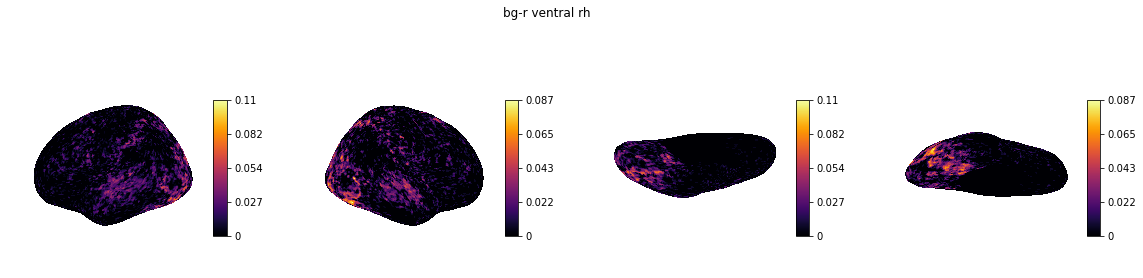

In [17]:
plot_infl(gii_dir, 'bg-r', 'inferno')

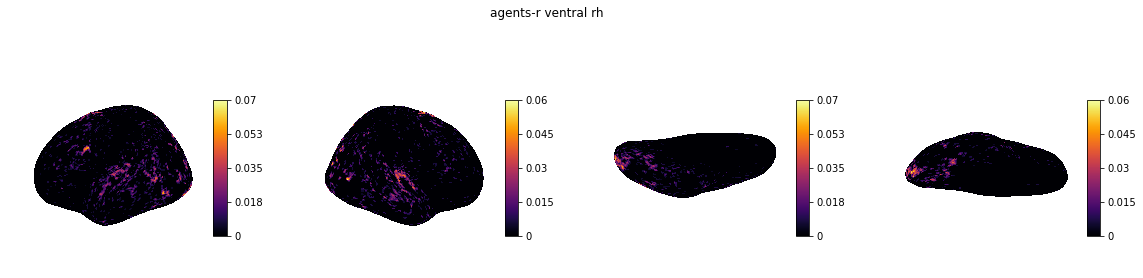

In [18]:
plot_infl(gii_dir, 'agents-r', 'inferno')

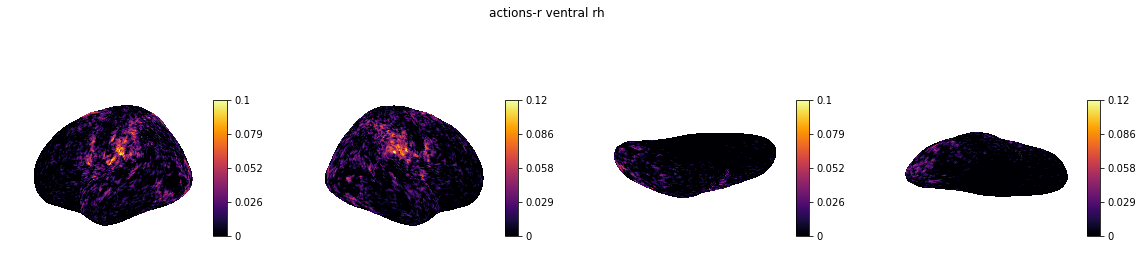

In [19]:
plot_infl(gii_dir, 'actions-r', 'inferno')